In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

In [0]:
class Deck:
    def __init__(self):
        self.cards={'A':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'J':10,'Q':10,'K':10}

    def draw(self):
        drawn_card=np.random.choice(list(self.cards))
        return self.cards[drawn_card]


class Player:
    def __init__(self,policy):
        self.reset()
        self.policy=policy

    # Reset all the cards
    def reset(self):
        self.hand=[]
        self.usable=0    # whether an ace is usable or not
        self.sum_hand=0
        self.hist=[]

    # Start the game and deal the cards, player also plays till sum of cards>11 
    def deal(self,deck):
        # Draw two cards from deck
        self.hand.append(deck.draw())
        self.hand.append(deck.draw())

        # Calculate sum of cards taking care of ace
        self.sum_hand=sum(self.hand)
        if 1 in self.hand:            # If have ace in hand, then it is usable
            self.usable=1
            self.sum_hand+=10
        
        # Keep drawing cards until sum is greater than 11
        while self.sum_hand<=11:
            new_card=deck.draw()
            self.hand.append(new_card)
            if new_card==1:            # Ace
                if self.usable:
                    self.sum_hand+=1
                else:
                    if (self.sum_hand+11)>21:
                        self.sum_hand+=1
                    else:
                        self.usable=1
                        self.sum_hand+=11
            else:
                self.sum_hand+=new_card

        # self.hist.append(self.sum_hand)

    # Play the game until stopped or sum greater than 21
    def play(self,deck, opp_first_card=0, ES=False):
        # Try random state at start for exploring starts
        if ES:
            self.usable=np.random.choice([0,1])
            self.sum_hand=np.random.choice(range(12, 22))
            opp_first_card=np.random.choice(range(10))
            self.hist=[]
            action=0 if np.random.random()<0.5 else 1
            self.hist+=[self.usable, self.sum_hand, action]
            if action==0:
                new_card=deck.draw()
                self.hand.append(new_card)
                ace_count=int(self.usable)
                if new_card==1:
                    new_card=11
                    ace_count+=1
                self.sum_hand+=new_card
                while (self.sum_hand>21) and ace_count:
                    self.sum_hand-=10
                    ace_count-=1
                self.usable=int(ace_count==1)

        if (ES==False) or (self.hist[-1]==0):   # If previous move(in ES) was stick then stop
            # ace_count=sum([1 for i in self.hand if i==1])
            while self.sum_hand<=21:
                action=int(self.policy[self.usable,self.sum_hand-12,opp_first_card])
                self.hist+=[self.usable, self.sum_hand, action]
                if action==1:
                    break
                new_card=deck.draw()
                ace_count=int(self.usable)
                if new_card==1:
                    new_card=11
                    ace_count+=1
                self.sum_hand+=new_card
                while (self.sum_hand>21) and ace_count:
                    self.sum_hand-=10
                    ace_count-=1
                self.usable=int(ace_count==1)

    # Play a new game completely
    def play_whole_game(self,deck,opp_first_card=0,ES=False):
        self.reset()
        self.deal(deck)
        self.play(deck,opp_first_card,ES)

In [0]:
class Game:
    def __init__(self,deck,player,dealer,ES=False):
        self.deck=deck
        self.player=player
        self.dealer=dealer
        self.hist=[]
        self.ES=ES

    # Resets the game and changes the policy of the player
    def reset(self,P_pi):
        self.P_pi=P_pi
        self.hist=[]

    # Play the whole game by both players and return the reward and seq of states visited by the player
    def simulate(self):
        self.dealer.play_whole_game(self.deck)
        self.player.play_whole_game(self.deck, self.dealer.hand[0]-1, self.ES)
        # Arange history as- (usable ace, current_sum of player, action, dealer's first card)
        episode=[(self.player.hist[i],self.player.hist[i+1],self.player.hist[i+2],self.dealer.hand[0]) for i in range(0,len(self.player.hist),3)]   
        reward=0

        # After game is over give reward based on sum  
        if self.player.sum_hand>21:        # Player is busted
            reward=-1
        elif self.dealer.sum_hand>21:      # Dealer is busted
            reward=1
        else:
            if self.player.sum_hand==self.dealer.sum_hand:    # Draw
                reward=0
            elif self.player.sum_hand>self.dealer.sum_hand:   # Player won
                reward=1
            else:                                             # Dealer won
                reward=-1
        return reward,episode

## Figure- 5.1

In [0]:
deck=Deck()

# Policy; action=0 -> hit and action=1 -> stick 
player_PI=np.zeros((2,10,10))   # (usable ace, current_sum(12-21), dealer_first_card)
player_PI[:,[8,9],:]=1          # hit when current_sum >=20

dealer_PI=np.zeros((2,10,10))   # (usable ace, current_sum(12-21), dealer_first_card)
dealer_PI[:,5:,:]=1             # Hit when current_sum >=17

player=Player(player_PI)
dealer=Player(dealer_PI)

game=Game(deck,player,dealer)

In [0]:
def policy_evaluation(epochs):
    for _ in range(epochs):
        G,hist=game.simulate()
        # print(G,hist)
        for usable,sum_hand,action,dealer_first in hist[::-1]:    # Start from the end
            sum_hand-=12            # Just to correct the axis 
            dealer_first-=1
            returns[usable,sum_hand,dealer_first]+=G
            n[usable,sum_hand,dealer_first]+=1
    V=returns/n
    return V[0],V[1]

V=np.zeros((2,10,10))      # (usable, current_sum(12-21), dealer_first_card)
returns=np.zeros((2,10,10))
n=np.zeros((2,10,10))
V_10k_unusable, V_10k_usable=policy_evaluation(10000)

V=np.zeros((2,10,10))      # (usable, current_sum(12-21), dealer_first_card)
returns=np.zeros((2,10,10))
n=np.zeros((2,10,10))
V_500k_unusable, V_500k_usable=policy_evaluation(500000)

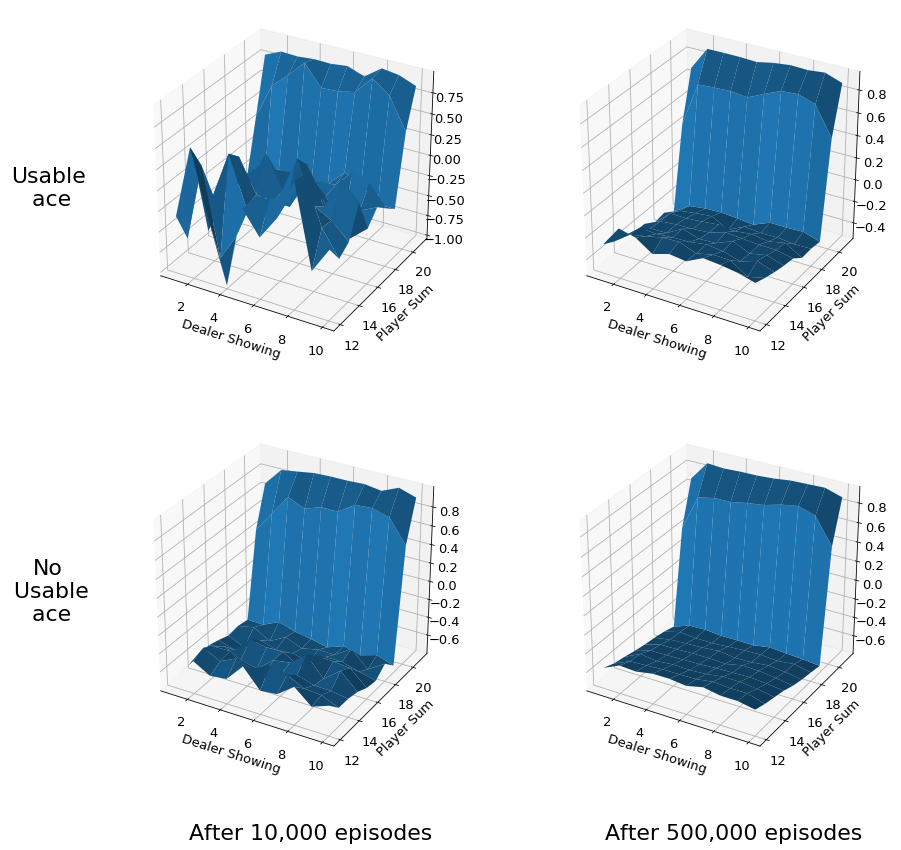

In [6]:
x,y=np.meshgrid(list(range(1,11)),range(12,22))     # 1 represents Ace
fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size': 13})

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x,y,V_10k_usable)
ax1.set(xlabel='Dealer Showing',ylabel='Player Sum')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x,y,V_500k_usable)
ax2.set(xlabel='Dealer Showing',ylabel='Player Sum')

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(x,y,V_10k_unusable)
ax3.set(xlabel='Dealer Showing',ylabel='Player Sum')

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(x,y,V_500k_unusable)
ax4.set(xlabel='Dealer Showing',ylabel='Player Sum')

fig.text(0.06, 0.70, 'Usable\n ace', ha='center', va='center',fontsize=22)
fig.text(0.06, 0.30, 'No\n Usable\n ace', ha='center', va='center',fontsize=22)
fig.text(0.32, 0.06, 'After 10,000 episodes', ha='center', va='center',fontsize=22)
fig.text(0.74, 0.06, 'After 500,000 episodes', ha='center', va='center',fontsize=22)

plt.show()

## Figure- 5.2

In [0]:
# Policy; action=0 -> hit and action=1 -> stick 
player_PI=np.zeros((2,10,10))   # (usable ace, current_sum(12-21), dealer_first_card)
player_PI[:,[8,9],:]=1          # stick when current_sum >=20

dealer_PI=np.zeros((2,10,10))   # (usable ace, current_sum(12-21), dealer_first_card)
dealer_PI[:,5:,:]=1             # stick when current_sum >=17

deck=Deck()
player=Player(player_PI)
dealer=Player(dealer_PI)

game=Game(deck,player,dealer,ES=True)

In [0]:
# Every-Visit Monte Carlo with exploring starts 
def MCES(Q,n):
    for _ in range(500000):
        G,hist=game.simulate()
        for usable,sum_hand,action,dealer_first in hist[::-1]:    # Start from the end
            sum_hand-=12            # To correct the axis 
            dealer_first-=1
            n[usable,sum_hand,action,dealer_first]+=1
            Q[usable,sum_hand,action,dealer_first]+=(G-Q[usable,sum_hand,action,dealer_first])/n[usable,sum_hand,action,dealer_first]
            game.player.policy[usable,sum_hand,dealer_first]=np.argmax(Q[usable,sum_hand,:,dealer_first])
    return Q[0],Q[1],n

Q=np.zeros((2,10,2,10))      # (usable ace, current_sum(12-21), action(0,1), dealer_first_card)
n=np.zeros((2,10,2,10))
Q_unusable, Q_usable, n=MCES(Q,n)

In [0]:
# Get optimal value function from optimal state-action value function
V_usable=Q_usable.max(axis=1)
V_unusable=Q_unusable.max(axis=1)

no_usable_pi, usable_pi =game.player.policy

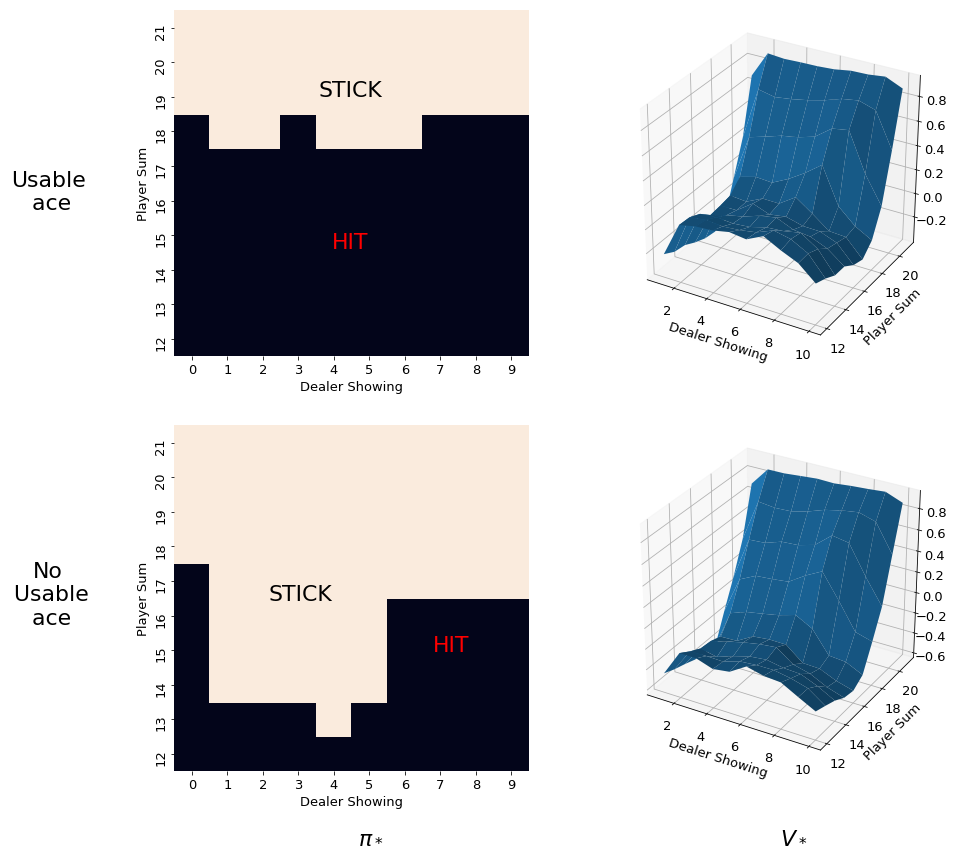

In [10]:
x,y=np.meshgrid(list(range(1,11)),range(12,22))     # 1 represents Ace
fig = plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size': 13})

ax1 = fig.add_subplot(221)
ax1=sns.heatmap(usable_pi,yticklabels=range(12,22),cbar=False)
ax1.set(xlabel='Dealer Showing',ylabel='Player Sum')
ax1.invert_yaxis()

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x,y,V_usable)
ax2.set(xlabel='Dealer Showing',ylabel='Player Sum')

ax3 = fig.add_subplot(223)
ax3=sns.heatmap(no_usable_pi,yticklabels=range(12,22),cbar=False)
ax3.set(xlabel='Dealer Showing',ylabel='Player Sum')
ax3.invert_yaxis()

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(x,y,V_unusable)
ax4.set(xlabel='Dealer Showing',ylabel='Player Sum')

fig.text(0.3, 0.8, 'STICK', ha='center', va='center',fontsize=22)
fig.text(0.3, 0.65, 'HIT', ha='center', va='center',fontsize=22,color='red')

fig.text(0.25, 0.3, 'STICK', ha='center', va='center',fontsize=22)
fig.text(0.4, 0.25, 'HIT', ha='center', va='center',fontsize=22,color='red')

fig.text(0, 0.70, 'Usable\n ace', ha='center', va='center',fontsize=22)
fig.text(0, 0.30, 'No\n Usable\n ace', ha='center', va='center',fontsize=22)
fig.text(0.32, 0.06, r'$\pi_*$', ha='center', va='center',fontsize=22)
fig.text(0.74, 0.06, r'$V_*$', ha='center', va='center',fontsize=22)

plt.show()

## Example 6.2

In [0]:
# get +1 reward if at state right terminal state else 0 reward 
def get_reward(s):
    return s==5

# Random policy for all states
# 0 means move left and 1 means move right 
def policy(s):
    return np.random.choice([0,1])

# Check for terminal states
def is_terminal(s):
    return (s==5) or (s==-1)

# Calculate RMSE between x and actual values- [1/6,2/6,3/6,4/6,5/6]
def RMSE(x):
    y=np.arange(1/6,1-1/6,1/6)
    return np.sqrt(np.mean((np.array(x)-y)**2))

In [0]:
def move(state):
    action=policy(state)
    if action==0:
        state-=1
    else:
        state+=1
    reward=get_reward(state)
    return reward, state

In [0]:
def TD0(epochs,alpha=0.1,gamma=1):
    # Value function of all states is 0.5 initially except the terminal state
    V=np.ones(6)*0.5
    V[-1]=0 
    for epoch in range(epochs):
        # if epoch in [0,1,10,100]:     # used for drawing left graph of example 6.2
        #     yield epoch,V[:-1]
        state=2                 # Starting state
        while True:
            if is_terminal(state):
                break
            reward,new_state=move(state)      
            V[state]=V[state]+alpha*(reward+gamma*V[new_state]-V[state])
            state=new_state
        yield V[:-1]

In [0]:
def MC(epochs,alpha=0.1,gamma=1):
    V=np.ones(6)*0.5
    V[-1]=0 
    for epoch in range(epochs):
        state_hist=[2]    # Starting state
        while True:
            if is_terminal(state_hist[-1]):
                break
            reward,state=move(state_hist[-1])
            state_hist.append(state)
        for i in state_hist[::-1][1:]:        # Remove the terminal state and reverse the states visited 
            V[i]=V[i]+alpha*(reward-V[i])
        yield V[:-1]

**Left Figure**

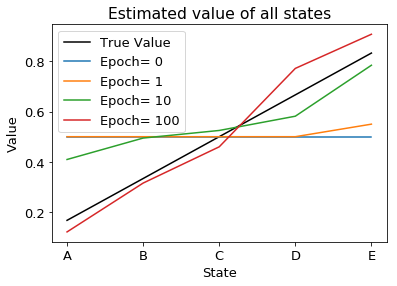

In [19]:
plt.plot(np.arange(1/6,1-1/6,1/6),  label="True Value",color='black')
for epoch,V in TD0(101):
    plt.plot(V,label="Epoch= {}".format(epoch))
plt.legend()
plt.xticks(range(0,5), ['A','B','C','D','E'])
plt.xlabel('State')
plt.ylabel('Value')
plt.title("Estimated value of all states")
plt.show()

**Right Figure**

In [0]:
# Get averaged values for 100 runs given method (TD0 or MC) and alpha
def RMSE_averaged(method,alpha):
    V=np.zeros((100,100))
    
    # 100 runs of 100 epochs each
    for run in range(100):
        for i,val in enumerate(method(100,alpha=alpha)):
            V[run,i]=RMSE(val)

    return V.mean(axis=0)

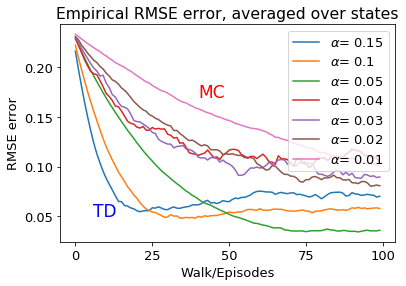

In [22]:
plt.plot(RMSE_averaged(TD0,0.15),label=r'$\alpha$= {}'.format(0.15))
plt.plot(RMSE_averaged(TD0,0.10),label=r'$\alpha$= {}'.format(0.10))
plt.plot(RMSE_averaged(TD0,0.05),label=r'$\alpha$= {}'.format(0.05))

plt.plot(RMSE_averaged(MC,0.04),label=r'$\alpha$= {}'.format(0.04))
plt.plot(RMSE_averaged(MC,0.03),label=r'$\alpha$= {}'.format(0.03))
plt.plot(RMSE_averaged(MC,0.02),label=r'$\alpha$= {}'.format(0.02))
plt.plot(RMSE_averaged(MC,0.01),label=r'$\alpha$= {}'.format(0.01))

plt.text(5.64,0.05,"TD",fontsize=17,color='blue')
plt.text(40,0.17,"MC",fontsize=17,color='red')
plt.legend()
plt.xlabel('Walk/Episodes')
plt.ylabel('RMSE error')
plt.title('Empirical RMSE error, averaged over states')
plt.xticks(range(0,101,25))
plt.show()

# Ans-7

In [0]:
w,h=12,4

def is_cliff(r,c):
    return (r==3) and (1<=c<=10)

def get_reward(r,c):
    if is_cliff(r,c):
        return -100
    return -1

def is_goal(r,c):
    return r==3 and c==11

def is_start(r,c):
    return r==3 and c==0

def is_terminal(r,c):
    return is_goal(r,c) or is_start(r,c)

# Policy is epsilon-greedy
def choose_action(Q,r,c,epsilon=0.1):
    if np.random.random()<epsilon:
        return int(np.random.choice([0,1,2,3]))
    else:
        return np.random.choice(np.where(np.max(Q[r,c])==Q[r,c])[0])

In [0]:
action_list={0:(-1,0),1:(0,1),2:(1,0),3:(0,-1)}

# Corrects the current state if out of bounds
def correct(r,c):
    if r<0:
        r=0
    elif r>=h:
        r=h-1
    if c<0:
        c=0
    elif c>=w:
        c=w-1
    return r,c 

# At current location (r,c), take action a and return corrected new location
def move(r,c,a):
    a_x,a_y=action_list[a]
    r=r+a_x
    c=c+a_y
    return correct(r,c)

**Sarsa**

In [0]:
epsilon=0.1
alpha=0.2
gamma=1

def reward_sarsa():
    reward_hist=np.zeros((1000,500))
    for run in range(1000):
        Q=np.zeros((h,w,4))    
        for epoch in range(500):
            state=3,0    # Start state
            action=choose_action(Q,state[0],state[1],epsilon)
            while not is_goal(state[0],state[1]):
                new_state=move(state[0],state[1],action)
                reward=get_reward(new_state[0],new_state[1])
                reward_hist[run,epoch]+=reward
                new_action=choose_action(Q,new_state[0],new_state[1])
                if is_cliff(new_state[0],new_state[1]):
                    new_state=3,0
                Q[state[0],state[1],action]+=alpha*(reward+gamma*Q[new_state[0],new_state[1],new_action]-Q[state[0],state[1],action])
                state=new_state
                action=new_action
    return reward_hist.mean(axis=0)

**Q-learning**

In [0]:
epsilon=0.1
alpha=0.2
gamma=1

def reward_q():
    reward_hist=np.zeros((1000,500))
    for run in range(1000):
        Q=np.zeros((h,w,4))    
        for epoch in range(500):
            state=3,0    # Start state
            while not is_goal(state[0],state[1]):
                action=choose_action(Q,state[0],state[1],epsilon)
                new_state=move(state[0],state[1],action)
                reward=get_reward(new_state[0],new_state[1])
                if is_cliff(new_state[0],new_state[1]):
                    new_state=3,0
                Q[state[0],state[1],action]+=alpha*(reward+gamma*np.max(Q[new_state[0],new_state[1],:])-Q[state[0],state[1],action])
                state=new_state
                reward_hist[run,epoch]+=reward
    return reward_hist.mean(axis=0)

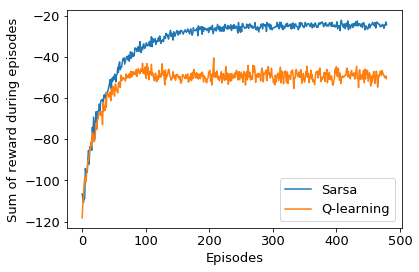

In [27]:
q=reward_q()
sarsa=reward_sarsa()
plt.plot(sarsa[20:],label='Sarsa')
plt.plot(q[20:],label='Q-learning')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Sum of reward during episodes')
plt.show()